In [1]:
!pip install scipy==1.6.3
!pip install scikit_optimize==0.8.1
!pip install scikit_learn==0.24.2
! git clone https://github.com/zykhoo/SeparableNNs.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 27.4 MB 113.1 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 101 kB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.3 MB 1.2 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scik

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np

experiment,sys,dim = "NN","TodaLatticePatient",6
f1 = lambda x: np.asarray([x[3], x[4], x[5]])
f2 = lambda x: np.asarray([-np.exp(x[0]-x[1])+np.exp(x[2]-x[0]),
                           -np.exp(x[1]-x[2])+np.exp(x[0]-x[1]),
                           -np.exp(x[2]-x[0])+np.exp(x[1]-x[2]),])
H = lambda x: 0.5*(x[3]**2+x[4]**2+x[5]**2)+np.exp(x[0]-x[1])+np.exp(x[1]-x[2])+np.exp(x[2]-x[0])-3

spacedim = [(-0.5,0.5),(-0.5,0.5),(-0.5,0.5),(-0.5,0.5),(-0.5,0.5),(-0.5,0.5)] # by using this spacedim, x<1 therefore x**2<1. the hamiltonian will usually be negative.
h= 0.01
x0, H0 = 0.,0.
initialcon = [64, 128, 256, 512, 1024, 2048] #, 4096, 8192
LR=0.01

"""# Test dataset creation"""

from SeparableNNs import groundtruth_2dim
from tqdm import tqdm
import time 

# xxshort,yyshort = np.linspace(spacedim[0][0], spacedim[0][1], 20), np.linspace(spacedim[1][0], spacedim[1][1], 20)
# xshort,yshort = np.meshgrid(xxshort,yyshort)

# H_true = H(np.c_[np.ravel(xshort),np.ravel(yshort)].transpose())
# sample_points = np.expand_dims(np.c_[np.ravel(xshort),np.ravel(yshort)],2)

# def get_H_grad(model, z,device):
#     inputs=torch.unsqueeze(Variable(torch.tensor([z[0][0],z[1][0]]), requires_grad = True),0).to(device)
#     out=model(inputs.float())
#     dH=torch.autograd.grad(out, inputs, grad_outputs=out.data.new(out.shape).fill_(1),create_graph=True, allow_unused=True)[0].detach().cpu().numpy()
#     return out.detach().cpu().numpy(), dH[0][1],-dH[0][0] # negative dH/dq is dp/dt

In [4]:
# NN takes in p, q, dq, dp, and learns the Hamiltonian. The derivative of the Hamiltonian is used for integration

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torch.nn.utils.prune as prune
import numpy as np
import os
import time
from tqdm import tqdm
import math

# define model
def softplus(x):
    return torch.log(torch.exp(x)+1)

from sklearn.model_selection import train_test_split


# class sepNet(nn.Module):

#     def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
#         super(sepNet , self).__init__()
#         self.mask1 = torch.cat((torch.squeeze(torch.cat((torch.ones((1,int(input_size/2))),torch.zeros((1,int(input_size/2)))),1),0).repeat(int(hidden_size1),1),
#             torch.squeeze(torch.cat((torch.zeros((1,int(input_size/2))),torch.ones((1,int(input_size/2)))),1),0).repeat(int(hidden_size1),1)),0)
#         self.mask2 = torch.cat((torch.squeeze(torch.cat((torch.ones((1,int(hidden_size1))),torch.zeros((1,int(hidden_size1)))),1),0).repeat(int(hidden_size2),1),
#                     torch.squeeze(torch.cat((torch.zeros((1,int(hidden_size1))),torch.ones((1,int(hidden_size1)))),1),0).repeat(int(hidden_size2),1)),0)
#         self.mask3 = torch.cat((torch.squeeze(torch.cat((torch.ones((1,int(hidden_size2))),torch.zeros((1,int(hidden_size2)))),1),0).repeat(int(output_size),1),
#                     torch.squeeze(torch.cat((torch.zeros((1,int(hidden_size2))),torch.ones((1,int(hidden_size2)))),1),0).repeat(int(output_size),1)),0)
#         self.hidden_layer_1 = nn.Linear( input_size, hidden_size1*2, bias=True)
#         with torch.no_grad():
#             self.hidden_layer_1.weight.mul_(self.mask1)
#         self.hidden_layer_2 = nn.Linear( hidden_size1*2, hidden_size2*2, bias=True)
#         with torch.no_grad():
#             self.hidden_layer_2.weight.mul_(self.mask2)
#         self.output_layer = nn.Linear( hidden_size2*2, output_size*2 , bias=True)
#         with torch.no_grad():
#             self.output_layer.weight.mul_(self.mask3)
#         prune.custom_from_mask(self.hidden_layer_1, name='weight', mask=self.mask1)
#         prune.custom_from_mask(self.hidden_layer_2, name='weight', mask=self.mask2)
#         prune.custom_from_mask(self.output_layer, name='weight', mask=self.mask3)
        
#     def forward(self, x):
#         x = softplus(self.hidden_layer_1(x)) # F.relu(self.hidden_layer_1(x)) # 
#         x = softplus(self.hidden_layer_2(x)) # F.relu(self.hidden_layer_2(x)) # 
#         x = self.output_layer(x)
#         x = torch.sum(x)
#         return x


# PINN
class Net(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(Net , self).__init__()
        self.hidden_layer_1 = nn.Linear( input_size, hidden_size, bias=True)
        self.hidden_layer_2 = nn.Linear( hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear( hidden_size, output_size , bias=True)
        
    def forward(self, x):
        x = softplus(self.hidden_layer_1(x)) # F.relu(self.hidden_layer_1(x)) # 
        x = softplus(self.hidden_layer_2(x)) # F.relu(self.hidden_layer_2(x)) # 
        x = self.output_layer(x)

        return x

class SumNet(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(SumNet , self).__init__()
        self.hidden_layer_1 = nn.Linear( input_size, hidden_size, bias=True)
        self.hidden_layer_2 = nn.Linear( hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear( hidden_size, 2 , bias=True)
        
    def forward(self, x):
        x = softplus(self.hidden_layer_1(x)) # F.relu(self.hidden_layer_1(x)) # 
        x = softplus(self.hidden_layer_2(x)) # F.relu(self.hidden_layer_2(x)) # 
        x = self.output_layer(x)
        x = torch.sum(x)

        return x

# calculate loss
def lossfuc(model,mat,x,y,device,x0,H0,dim,c1=1,c2=1,c3=1,c4=1,verbose=False):
    dim = int(wholemat.shape[1]/2)
    f3=(model(torch.tensor([[x0]*dim]).to(device))-torch.tensor([[H0]]).to(device))**2
    dH=torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1),create_graph=True, allow_unused=True)[0]
    dHdq=dH[:,:int(dim/2)]
    dHdp=dH[:,int(dim/2):]
    qprime=(mat[:,dim:int(3*dim/2)])
    pprime=(mat[:,int(3*dim/2):])
    assert dHdq.shape[1] == int(dim/2)
    assert dHdp.shape[1] == int(dim/2)
    assert qprime.shape[1] == int(dim/2)
    assert pprime.shape[1] == int(dim/2)
    f1=torch.mean((dHdp-qprime)**2,dim=0)
    # print(dHdq, pprime)
    f2=torch.mean((dHdq+pprime)**2,dim=0)
    f4=torch.mean((dHdq*qprime+dHdp*pprime)**2,dim=0)
    loss=torch.mean(c1*f1+c2*f2+c3*f3+c4*f4)
    if loss > 1000: print("errors:", f1, f2, f3, f4)
    meanf1,meanf2,meanf3,meanf4=torch.mean(c1*f1),torch.mean(c2*f2),torch.mean(c3*f3),torch.mean(c4*f4)
    if verbose:
      print(x)
      print(meanf1,meanf2,meanf3,meanf4)
      print(loss,meanf1,meanf2,meanf3,meanf4)
    return loss,meanf1,meanf2,meanf3,meanf4


def data_preprocessing(start_train, final_train,device):       
    # wholemat=[]
    # for i in range(len(start_train[0,:])):
    #     wholemat.append(np.vstack((
    #         np.hstack((start_train[:,i], (final_train[:,i]-start_train[:,i])/h)),
    #         np.hstack((final_train[:,i], (final_train[:,i]-start_train[:,i])/h)))))
    wholemat = np.hstack((start_train.transpose(), final_train.transpose()))

    wholemat =torch.tensor(wholemat)
    wholemat=wholemat.to(device)

    wholemat,evalmat=train_test_split(wholemat, train_size=0.8, random_state=1)

    return wholemat,evalmat

## train

# evaluate loss of dataset 
def get_loss(model,device,initial_conditions,bs,x0,H0,dim,wholemat,evalmat,c1,c2,c3,c4,trainset=False,verbose=False):
    # this function is used to calculate average loss of a whole dataset
    # rootpath: path of set to be calculated loss
    # model: model
    # trainset: is training set or not


    if trainset:
        mat=wholemat
    else:
        mat=evalmat
    avg_loss=0
    avg_f1=0
    avg_f2=0
    avg_f3=0
    avg_f4=0
    for count in range(0,len(mat),bs):
      curmat=mat[count:count+bs]
      x=Variable((curmat[:,:dim]).float(),requires_grad=True)
      y=model(x)
      x=x.to(device)
      loss,f1,f2,f3,f4=lossfuc(model,curmat,x,y,device,x0,H0,dim,c1,c2,c3,c4)
      avg_loss+=loss.detach().cpu().item()
      avg_f1+=f1.detach().cpu().item()
      avg_f2+=f2.detach().cpu().item()
      avg_f3+=f3.detach().cpu().item()
      avg_f4+=f4.detach().cpu().item()
    num_batches=len(mat)//bs
    avg_loss/=num_batches
    avg_f1/=num_batches
    avg_f2/=num_batches
    avg_f3/=num_batches
    avg_f4/=num_batches
    if verbose:
        print(' loss=',avg_loss,' f1=',avg_f1,' f2=',avg_f2,' f3=',avg_f3,' f4=',avg_f4)
    return avg_loss


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            上次验证集损失值改善后等待几个epoch
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            如果是True，为每个验证集损失值改善打印一条信息
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            监测数量的最小变化，以符合改进的要求
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if abs(self.counter-self.patience)<5:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''
        Saves model when validation loss decrease.
        验证损失减少时保存模型。
        '''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), 'checkpoint.pt')     # 这里会存储迄今最优模型的参数
        torch.save(model, 'checkpoint.pt')                 # 这里会存储迄今最优的模型
        self.val_loss_min = val_loss

def train(net,bs,num_epoch,initial_conditions,device,wholemat,evalmat,x0,H0,dim,LR,patience,c1,c2,c3,c4):
    # function of training process
    # net: the model
    # bs: batch size 
    # num_epoch: max of epoch to run
    # initial_conditions: number of trajectory in train set
    # patience: EarlyStopping parameter
    # c1~c4: hyperparameter for loss function


    avg_lossli,avg_f1li,avg_f2li,avg_f3li,avg_f4li=[],[],[],[],[]
    avg_vallosses=[]
    
    start = time.time()
    lr = LR # initial learning rate
    net=net.to(device)

    early_stopping = EarlyStopping(patience=patience, verbose=False,delta=0.00001) # delta
    optimizer=torch.optim.Adam(net.parameters() , lr=lr )
    for epoch in range(num_epoch):

        running_loss=0

        running_f1=0
        running_f2=0
        running_f3=0
        running_f4=0
        num_batches=0
        
        # train
        shuffled_indices=torch.randperm(len(wholemat))
        net.train()
        for count in range(0,len(wholemat),bs):
            optimizer.zero_grad()

            indices=shuffled_indices[count:count+bs]
            mat=wholemat[indices]

            x=Variable(torch.tensor(mat[:,:dim]).float(),requires_grad=True)
            y=net(x)

            loss,f1,f2,f3,f4=lossfuc(net,mat,x,y,device,x0,H0,dim,c1,c2,c3,c4)  
            loss.backward()
            torch.nn.utils.clip_grad_norm(net.parameters(), 1)

            optimizer.step()

            # compute some stats
            running_loss += loss.detach().item()
            running_f1 += f1.detach().item()
            running_f2 += f2.detach().item()
            running_f3 += f3.detach().item()
            running_f4 += f4.detach().item()

            num_batches+=1
            torch.cuda.empty_cache()



        avg_loss = running_loss/num_batches
        avg_f1 = running_f1/num_batches
        avg_f2 = running_f2/num_batches
        avg_f3 = running_f3/num_batches
        avg_f4 = running_f4/num_batches
        elapsed_time = time.time() - start
        
        avg_lossli.append(avg_loss)
        avg_f1li.append(avg_f1)
        avg_f2li.append(avg_f2)
        avg_f3li.append(avg_f3)
        avg_f4li.append(avg_f4)
        
        
        # evaluate
        net.eval()
        avg_val_loss=get_loss(net,device,len(evalmat),bs,x0,H0,dim,wholemat,evalmat,c1,c2,c3,c4)
        avg_vallosses.append(avg_val_loss)
        
        if epoch % 100 == 0 : 
            print(' ')
            print('epoch=',epoch, ' time=', elapsed_time,
                  ' loss=', avg_loss ,' val_loss=',avg_val_loss,' f1=', avg_f1 ,' f2=', avg_f2 ,
                  ' f3=', avg_f3 ,' f4=', avg_f4 , 'num_batches=', num_batches, 'percent lr=', optimizer.param_groups[0]["lr"] )
        
        
        
        early_stopping(avg_val_loss,net)
        if early_stopping.early_stop:
            print('Early Stopping')
            break
            
    net=torch.load('checkpoint.pt')
    return net,epoch,avg_vallosses,avg_lossli,avg_f1li,avg_f2li,avg_f3li,avg_f4li

class splitBalancedLinear(nn.Module):

    def __init__(self, input_size, output_size):
        # output_size is the size of one of the two parallel networks
        super(splitBalancedLinear , self).__init__()
        self.input_size, self.output_size = input_size, output_size
        weights = torch.Tensor(2,self.input_size,self.output_size)
        self.weights = nn.Parameter(weights)
        bias = torch.Tensor(2,1,self.output_size)
        self.bias = nn.Parameter(bias)

        # initialise weights and bias
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5)) 
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)  # bias init
        
    def forward(self, x):
        # print(self.weights, self.bias)
        # print("mul", torch.einsum('ijk,ikl->ijl', x, self.weights))
        # print("add", torch.add(torch.einsum('ijk,ikl->ijl', x, self.weights), self.bias))
        return torch.add(torch.einsum('ijk,ikl->ijl', x, self.weights), self.bias)
        # return F.linear(x, self.weights, self.bias)

class sepNet(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(sepNet , self).__init__()
        self.hidden_layer_1 = splitBalancedLinear(input_size, hidden_size1)
        self.hidden_layer_2 = splitBalancedLinear(hidden_size1, hidden_size2)
        self.output_layer = splitBalancedLinear(hidden_size2, output_size)
        
    def forward(self, x):
        # print("input", x.shape)
        # print(x)
        x = torch.stack((x[:,:int(x.shape[-1]/2)],x[:,int(x.shape[-1]/2):]))
        # print(x)
        # print("initial", x.shape)
        x = softplus(self.hidden_layer_1(x)) 
        # print(x)
        # print("hl1", x.shape)
        x = softplus(self.hidden_layer_2(x)) 
        # print(x)
        # print("hl2", x.shape)
        x = self.output_layer(x)
        # print(x)
        # print("output", x.shape)
        x = torch.sum(x)
        return x

In [5]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
from matplotlib import cm
from SeparableNNs.models import PINN
import torch
from SeparableNNs import metrics

for i in [12,13,14,15,16,17,18,19]:
  seed = i
  np.random.seed(seed=seed)
  for ini in initialcon: 

    start, final = groundtruth_2dim.CreateTrainingDataTrajStormer(1,ini,spacedim,h,f1,f2,seed = seed,n_h = 1)

    delta = (final-start)/h

    # delta2 = delta.copy()
    # delta2[0,:] = f1(start)
    # delta2[1,:] = f2(start)
    # dq_MSE = np.mean(np.square(delta2[0,:]-delta[0,:]))
    # dp_MSE = np.mean(np.square(delta2[1,:]-delta[1,:]))
    # data_MSE = np.mean(np.square(np.sqrt(delta[0,:]**2 + delta[1,:]**2)-np.sqrt(delta2[0,:]**2 + delta2[1,:]**2)))

    """# sepNN"""

    

    if torch.cuda.is_available():
      device=torch.device('cuda')
    else:
      device=torch.device('cpu')
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    wholemat, evalmat = PINN.data_preprocessing(start, delta,device)    

    import torch.optim as optim
    import time 


    sepnet = sepNet(3,44,44,1) #sepnet = sepNet(3,22,22,1)
    starttime = time.time() 
    print("training sepNet")

    results = train(sepnet,bs=min(int(len(wholemat)/5), 128),num_epoch=10000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=2500,c1=1,c2=1,c3=1,c4=1)
    # results = PINN.train(sepnet,bs=10,num_epoch=5000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=100,c1=1,c2=1,c3=1,c4=1)
    sepnet, epochs = results[0], results[1]
    septraintime = time.time()-starttime
    torch.save(sepnet.state_dict(), '/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/%s_%s_%s_%s.pt' %(sys,sys,"sepNN",seed,ini))

    # H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
    # for i in tqdm(range(len(sample_points))):
    #   out = get_H_grad(sepnet, sample_points[i], device)
    #   H_pred[i] = out[0]
    #   dq_pred[i] = out[1]
    #   dp_pred[i] = out[2]
    # print(H_pred.shape, dq_pred.shape, dp_pred.shape)
    # file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_results.txt' %(sys,sys), 'a') 
    # file_object.write('sepNN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
    #       %(ini, seed, dq_MSE, dp_MSE, data_MSE, septraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
    #       np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
    #       np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
    # file_object.close()
    
    # H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)

    # plt.figure(figsize = (10,10))
    # plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
    # plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
    # plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "sepNN"))

    net = Net(6,62,1)
    starttime = time.time() 
    print("training PINN Net")
    
    results = train(net,bs=min(int(len(wholemat)/5), 128),num_epoch=10000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=2500,c1=1,c2=1,c3=1,c4=1)
    net, epochs = results[0], results[1]
    PINNtraintime = time.time()-starttime
    torch.save(net.state_dict(), '/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/%s_%s_%s_%s.pt' %(sys,sys,"PINN",seed,ini))

    # H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
    # for i in tqdm(range(len(sample_points))):
    #   out = get_H_grad(net, sample_points[i], device)
    #   H_pred[i] = out[0]
    #   dq_pred[i] = out[1]
    #   dp_pred[i] = out[2]
    # print(H_pred.shape, dq_pred.shape, dp_pred.shape)
    # file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_results.txt' %(sys,sys), 'a')
    # file_object.write('PINN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
    #       %(ini, seed, dq_MSE, dp_MSE, data_MSE, PINNtraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
    #       np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
    #       np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
    # file_object.close()
    
    # H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)
    
    # plt.figure(figsize = (10,10))
    # plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
    # plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
    # plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "PINN"))

    # print(septraintime, PINNtraintime)

training sepNet
 
epoch= 0  time= 0.10929274559020996  loss= 1.1853525009958106  val_loss= 1.9035849327907723  f1= 0.09044646658510837  f2= 0.5474802026843827  f3= 0.5474218005935351  f4= 4.0311327843910876e-06 num_batches= 6 percent lr= 0.01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:258: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:263: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Streaming output truncated to the last 5000 lines.
 
epoch= 5400  time= 56.64054584503174  loss= 8.040990396456032e-05  val_loss= 0.000736221460090088  f1= 1.3771700646022326e-05  f2= 3.7775065352491515e-05  f3= 1.7479452916783583e-05  f4= 1.1383685049262897e-05 num_batches= 6 percent lr= 0.01
 
epoch= 5500  time= 57.66766166687012  loss= 8.513310362457995e-05  val_loss= 0.000729903550502282  f1= 2.6462164750997135e-05  f2= 3.626159436176962e-05  f3= 4.0105604697989366e-06  f4= 1.8398784042014264e-05 num_batches= 6 percent lr= 0.01
 
epoch= 5600  time= 58.68462014198303  loss= 3.667419016944431e-05  val_loss= 0.000967820653551381  f1= 9.358385155794908e-06  f2= 1.842656144830894e-05  f3= 1.4789303719453528e-06  f4= 7.410313193395112e-06 num_batches= 6 percent lr= 0.01
 
epoch= 5700  time= 59.71552395820618  loss= 0.00010302900801539503  val_loss= 0.001390942080066389  f1= 1.613248342956549e-05  f2= 5.575239875825317e-05  f3= 2.059067583104479e-05  f4= 1.0553449996531601e-05 num_batches

In [ ]:
# n_sample = 20
# dim = 6

# z = torch.tensor(np.array(np.meshgrid(np.linspace(spacedim[0][0], spacedim[0][1], n_sample),np.linspace(spacedim[1][0], spacedim[1][1],n_sample),
#                                       np.linspace(spacedim[2][0], spacedim[2][1],n_sample),np.linspace(spacedim[3][0], spacedim[3][1],n_sample),
#                                       np.linspace(spacedim[4][0], spacedim[4][1],n_sample),np.linspace(spacedim[5][0], spacedim[5][1],n_sample),
#                                       ))).reshape(6, n_sample**dim).transpose(1,0)
# for i in tqdm(range(dim**2)):
#   np.savetxt('/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/test%s.txt' %(sys,i), z[n_sample**4*i:n_sample**4*(i+1), :])

In [7]:
from tqdm import tqdm

n_sample = 20 # 6

sepnet_total, net_total = [],[]
for seed in tqdm(range(20)):
  for ini in initialcon:
    net = Net(6,62,1)
    net.load_state_dict(torch.load('/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/%s_%s_%s_%s.pt' %(sys,sys,"PINN",seed,ini)))

    sepnet = sepNet(3,44,44,1) #PINN.sepNet(2,11,11,1)
    sepnet.load_state_dict(torch.load('/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/%s_%s_%s_%s.pt' %(sys,sys,"sepNN",seed,ini)))

    def get_grad(model, z,device):
      inputs=Variable(z.clone().detach()).requires_grad_(True).to(device)
      out=model(inputs.float())
      dH=torch.autograd.grad(out, inputs, grad_outputs=out.data.new(out.shape).fill_(1),create_graph=True)[0]
      return np.asarray([dH.detach().cpu().numpy()[:,3], dH.detach().cpu().numpy()[:,4], dH.detach().cpu().numpy()[:,5],
                         -dH.detach().cpu().numpy()[:,0], -dH.detach().cpu().numpy()[:,1], -dH.detach().cpu().numpy()[:,2], ]) # negative dH/dq is dp/dt
      # return np.asarray([dH.detach().to(device).numpy()[:,3], dH.detach().to(device).numpy()[:,4], dH.detach().to(device).numpy()[:,5],
      #               -dH.detach().to(device).numpy()[:,0], -dH.detach().to(device).numpy()[:,1], -dH.detach().to(device).numpy()[:,2], ]) # negative dH/dq is dp/dt

    
    f1 = lambda x: np.stack([x[:,3], x[:,4], x[:,5]])
    f2 = lambda x: np.stack([-np.exp(x[:,0]-x[:,1])+np.exp(x[:,2]-x[:,0]),
                              -np.exp(x[:,1]-x[:,2])+np.exp(x[:,0]-x[:,1]),
                              -np.exp(x[:,2]-x[:,0])+np.exp(x[:,1]-x[:,2]),])



    fvec = lambda z: np.concatenate([f1(z), f2(z)])
    error = lambda x,y: np.sum(np.sqrt(np.sum((x-y)**2,0))/np.sqrt(np.sum(x**2,0))) # where x is the true vector and y is the approximated vector

    

    sepnet_error, net_error = 0, 0
    for i in range(6**2):
      inpz = torch.tensor(np.loadtxt('/content/drive/MyDrive/CIKM2022/Toda Lattice/TodaLatticeNA/test%s.txt' %(i)))
      sepnet_error += error(fvec(inpz), get_grad(sepnet, inpz, 'cpu'))
      net_error += error(fvec(inpz), get_grad(net, inpz, 'cpu'))
    sepnet_total.append(sepnet_error)
    net_total.append(net_error)
    print(ini, net_error, sepnet_error)

  0%|          | 0/20 [00:00<?, ?it/s]

64 122610.24124534734 67204.78072951897
128 70185.84849114282 33088.66380701064
256 62148.3603799422 38666.71624188101
512 49246.66805091394 34041.30362670815
1024 37993.27664967895 24576.560424957068


  5%|▌         | 1/20 [08:22<2:39:05, 502.38s/it]

2048 35424.19889274729 21541.8587357943
64 171440.1255213069 124947.80138826673
128 84150.06615074443 50486.57744469118
256 62803.64768711001 40992.37578070813
512 40501.98124300378 42627.77638228922
1024 38651.41672980544 26813.5722946453


 10%|█         | 2/20 [16:32<2:28:35, 495.33s/it]

2048 35536.01585906387 21755.128695341853
64 150922.34195072856 69349.5401756418
128 87973.80779598378 49979.413651042414
256 68972.05851996837 51516.912362298244
512 51496.20405009707 33635.7952823218
1024 38460.91418068458 25273.15703305497


 15%|█▌        | 3/20 [24:52<2:20:51, 497.16s/it]

2048 32931.8405715237 21168.1110453585
64 367227.67448962736 122813.49009179571
128 63504.129460447526 46491.31722173584
256 65542.3265298735 40584.58693231657
512 51394.18312306633 35714.44414237166
1024 41338.7012670154 25679.71846146888


 20%|██        | 4/20 [33:06<2:12:16, 496.04s/it]

2048 34970.41769327443 17351.661055131408
64 136162.52168948363 91451.952595664
128 83181.92915047734 46276.99608459054
256 63492.239382266234 47689.9620110852
512 45319.89517078076 35722.33558664761
1024 39697.89643308043 19512.590569115644


 25%|██▌       | 5/20 [41:18<2:03:39, 494.63s/it]

2048 36789.59549867978 20018.06836085279
64 110970.86748454532 52464.43542509379
128 84226.72178153154 47737.19793806036
256 61064.689016871984 40635.098977367656
512 44482.94602724357 39743.532283168825
1024 40137.4145399335 32349.285956011034


 30%|███       | 6/20 [49:34<1:55:31, 495.13s/it]

2048 37098.329388859114 20899.498718519266
64 134019.62001673316 77440.31072142784
128 79397.12465691393 52193.64362556781
256 48763.598344609054 37171.47149431888
512 44366.62410414983 37804.25221491055
1024 48061.41315206666 32481.902952678123


 35%|███▌      | 7/20 [57:50<1:47:21, 495.47s/it]

2048 32239.04856744209 23136.08620707217
64 120894.19847005163 82136.6347274787
128 91885.61474136836 44324.69637752143
256 59628.231116804134 40811.15883720243
512 48500.577989534686 30429.761802187262
1024 42204.417231171596 24218.477723509448


 40%|████      | 8/20 [1:06:15<1:39:42, 498.55s/it]

2048 36289.02186844904 21482.00352773891
64 138445.10406130066 47042.240256038975
128 74287.46653249489 48308.821973032005
256 50741.08467004543 46045.48551708278
512 53581.68844414937 28776.14847156822
1024 37340.935443095696 34125.67604121652


 45%|████▌     | 9/20 [1:14:43<1:31:53, 501.27s/it]

2048 34466.5953841054 22829.63681135012
64 157213.2144707792 70815.28610517882
128 122541.67807260239 50048.97414292029
256 62148.18077597779 35254.76863607358
512 50363.69012694472 45788.418374754256
1024 34064.119625476495 31475.116824341192


 50%|█████     | 10/20 [1:23:08<1:23:46, 502.65s/it]

2048 38094.6633475531 23081.22881900506
64 124617.15688592858 81215.90353498604
128 83722.16718034359 60508.564810524986
256 59564.78800799807 38591.9661770959
512 45082.54176772549 33882.9130449357
1024 38002.220946864676 26450.93390467347


 55%|█████▌    | 11/20 [1:31:33<1:15:28, 503.16s/it]

2048 30291.738647119982 20768.767927573994
64 152443.18733251616 107781.40836023157
128 83740.3519751684 56961.8481908068
256 56888.93978805174 45182.95042620542
512 43819.71709058226 41830.05450586362
1024 40718.92785976064 27951.165982653663


 60%|██████    | 12/20 [1:40:02<1:07:18, 504.86s/it]

2048 37418.80358752975 23777.992578077068
64 141718.66024138915 59408.48835917398
128 72003.46428617284 50567.77580382156
256 48604.68052661894 44502.23355343158
512 65955.0435867178 45223.41904575371
1024 42943.268527161395 29290.821148713658


 65%|██████▌   | 13/20 [1:48:29<58:59, 505.59s/it]  

2048 29120.18536841209 26224.235792920015
64 122083.31418053285 70277.86813448695
128 74076.11937108786 47497.864767999905
256 63644.465977375716 43800.44076274338
512 46931.06425564805 28470.935213838464
1024 33013.84994758006 19256.033289613566


 70%|███████   | 14/20 [1:56:51<50:27, 504.59s/it]

2048 38604.33328421866 23414.231919253536
64 192714.0419572867 76378.20351064898
128 68151.97062019697 45980.028330782065
256 55014.549358905635 32528.728919163645
512 41544.24588276748 32414.471204414986
1024 34678.45390754358 24151.426505023253


 75%|███████▌  | 15/20 [2:05:11<41:56, 503.21s/it]

2048 35643.88757121314 22323.597324022994
64 197203.81456786575 87654.68301676057
128 111058.30528682983 48234.81975161459
256 54415.20613174284 53163.6576591053
512 44598.13963331713 31050.26618229378
1024 38412.199066240035 27381.789847851207


 80%|████████  | 16/20 [2:13:40<33:40, 505.05s/it]

2048 33423.425657069645 23260.766273689078
64 131729.83727029973 85178.103372811
128 77296.05984241085 44578.894852551384
256 63243.89864965025 30138.556181307325
512 36586.770796599914 38789.906911542304
1024 36570.97159605337 26047.014292289237


 85%|████████▌ | 17/20 [2:22:09<25:18, 506.01s/it]

2048 30631.82179084104 18926.77000609092
64 140684.2455289656 82608.70671319509
128 71205.58348432631 48880.26455900367
256 68188.82636249647 40430.29909422957
512 48026.28995185259 23799.285782667554
1024 37579.905661980796 20997.699874212933


 90%|█████████ | 18/20 [2:30:37<16:53, 506.80s/it]

2048 36640.38531218406 25299.005365529672
64 105987.7011833023 53023.81278863379
128 75235.99528561733 63429.22188085899
256 62483.500095997355 56434.468426572166
512 46949.438865575685 29553.946298476447
1024 42663.118226138184 22708.835296573212


 95%|█████████▌| 19/20 [2:39:06<08:27, 507.41s/it]

2048 37569.45669182076 24001.36218601792
64 121950.04970858501 93340.32548083988
128 78655.68404738638 41896.04371673478
256 48898.1595609069 34848.73324659804
512 45861.400304058305 31353.47814009315
1024 42814.33547475264 25073.003557183183


100%|██████████| 20/20 [2:47:30<00:00, 502.53s/it]

2048 37072.363946132304 28348.2273933596


In [8]:
sepnet_total, net_total = [np.mean(sepnet_total[i::len(initialcon)]) for i in range(len(initialcon))], [np.mean(net_total[i::len(initialcon)]) for i in range(len(initialcon))]

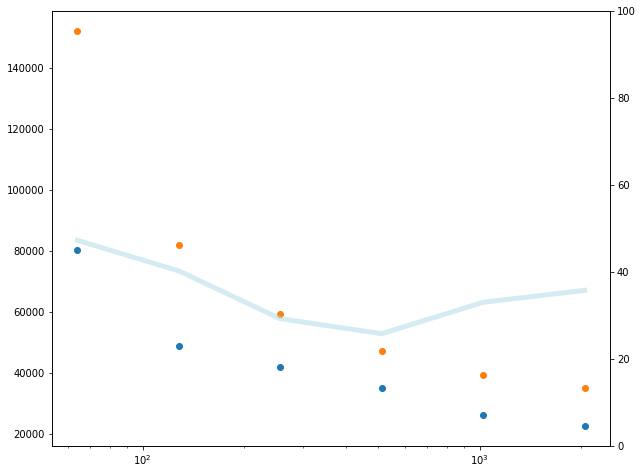

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10,8))
l1 = ax.scatter(initialcon, sepnet_total, label = "sepnet absolute error")
l2 = ax.scatter(initialcon, net_total, label = "net absolute error")
# ax.set_ylabel('absolute error')
ax2 = ax.twinx()
l3 = ax2.plot(initialcon, np.maximum(np.zeros(6), (np.array(net_total)-np.array(sepnet_total))/np.array(net_total)*100), color = "lightblue", linewidth = 5.0, alpha = 0.5, label = "percentage error reduction")
# ax2.set_ylabel('percentage error reduction')
ax2.set_ylim(0,100)
plt.xscale("log")
# fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

In [ ]:
# import matplotlib.pyplot as plt
# from torch.autograd import Variable
# from matplotlib import cm
# from understandingPINNs.models import PINN
# import torch
# from understandingPINNs import metrics

# for i in range(20):
#   seed = i
#   np.random.seed(seed=seed)
#   for ini in initialcon: 

#     start, final = groundtruth_2dim.CreateTrainingDataTrajStormer(1,ini,spacedim,h,f1,f2,seed = seed,n_h = 1)

#     delta = (final-start)/0.1
#     delta2 = delta.copy()
#     delta2[0,:] = f1(start)
#     delta2[1,:] = f2(start)
#     dq_MSE = np.mean(np.square(delta2[0,:]-delta[0,:]))
#     dp_MSE = np.mean(np.square(delta2[1,:]-delta[1,:]))
#     data_MSE = np.mean(np.square(np.sqrt(delta[0,:]**2 + delta[1,:]**2)-np.sqrt(delta2[0,:]**2 + delta2[1,:]**2)))

#     """# sumNN"""

    

#     if torch.cuda.is_available():
#       device=torch.device('cuda')
#     else:
#       device=torch.device('cpu')
#     print("device used", device)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)

#     wholemat, evalmat = PINN.data_preprocessing(start, delta,device)    

#     import torch.optim as optim
#     import time 


#     sumnet = PINN.SumNet(2,16,2)
#     starttime = time.time() 

#     results = PINN.train(sumnet,bs=10,num_epoch=5000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=100,c1=1,c2=1,c3=1,c4=1)
#     sumnet, epochs = results[0], results[1]
#     septraintime = time.time()-starttime
#     torch.save(sumnet.state_dict(), '/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_%s_%s_%s.pt' %(sys,sys,"sumNN",seed,ini))

#     H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
#     for i in tqdm(range(len(sample_points))):
#       out = get_H_grad(sumnet, sample_points[i], device)
#       H_pred[i] = out[0]
#       dq_pred[i] = out[1]
#       dp_pred[i] = out[2]
#     print(H_pred.shape, dq_pred.shape, dp_pred.shape)
#     file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_results.txt' %(sys,sys), 'a') 
#     file_object.write('sumNN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
#           %(ini, seed, dq_MSE, dp_MSE, data_MSE, septraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
#           np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
#           np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
#     file_object.close()
    
#     H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)

#     plt.figure(figsize = (10,10))
#     plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
#     plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
#     plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "sumNN"))

In [ ]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
from matplotlib import cm
from understandingPINNs.models import PINN
import torch
from understandingPINNs import metrics

for i in [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]:
  seed = i
  np.random.seed(seed=seed)
  for ini in initialcon: 

    start, final = groundtruth_2dim.CreateTrainingDataTrajSympEuler(1,ini,spacedim,h,f1,f2,seed = seed,n_h = 1)

    delta = (final-start)/0.1
    delta2 = delta.copy()
    delta2[0,:] = f1(start)
    delta2[1,:] = f2(start)
    dq_MSE = np.mean(np.square(delta2[0,:]-delta[0,:]))
    dp_MSE = np.mean(np.square(delta2[1,:]-delta[1,:]))
    data_MSE = np.mean(np.square(np.sqrt(delta[0,:]**2 + delta[1,:]**2)-np.sqrt(delta2[0,:]**2 + delta2[1,:]**2)))

    """# sepNN"""

    

    if torch.cuda.is_available():
      device=torch.device('cuda')
    else:
      device=torch.device('cpu')
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    wholemat, evalmat = PINN.data_preprocessing(start, delta,device)    

    import torch.optim as optim
    import time 


    sepnet = PINN.sepNet(1,11,11,1)
    starttime = time.time() 

    results = PINN.train(sepnet,bs=10,num_epoch=5000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=100,c1=1,c2=1,c3=1,c4=1)
    sepnet, epochs = results[0], results[1]
    septraintime = time.time()-starttime
    torch.save(sepnet.state_dict(), '/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_%s_%s_%s.pt' %(sys,sys,"sepNN",seed,ini))

    H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
    for i in tqdm(range(len(sample_points))):
      out = get_H_grad(sepnet, sample_points[i], device)
      H_pred[i] = out[0]
      dq_pred[i] = out[1]
      dp_pred[i] = out[2]
    print(H_pred.shape, dq_pred.shape, dp_pred.shape)
    file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_results.txt' %(sys,sys), 'a') 
    file_object.write('sepNN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
          %(ini, seed, dq_MSE, dp_MSE, data_MSE, septraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
          np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
          np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
    file_object.close()
    
    H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)

    plt.figure(figsize = (10,10))
    plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
    plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
    plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "sepNN"))

    net = PINN.Net(2,16,1)
    starttime = time.time() 
    
    results = PINN.train(net,bs=10,num_epoch=5000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=100,c1=1,c2=1,c3=1,c4=1)
    net, epochs = results[0], results[1]
    PINNtraintime = time.time()-starttime
    torch.save(net.state_dict(), '/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_%s_%s_%s.pt' %(sys,sys,"PINN",seed,ini))

    H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
    for i in tqdm(range(len(sample_points))):
      out = get_H_grad(net, sample_points[i], device)
      H_pred[i] = out[0]
      dq_pred[i] = out[1]
      dp_pred[i] = out[2]
    print(H_pred.shape, dq_pred.shape, dp_pred.shape)
    file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_results.txt' %(sys,sys), 'a')
    file_object.write('PINN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
          %(ini, seed, dq_MSE, dp_MSE, data_MSE, PINNtraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
          np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
          np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
    file_object.close()
    
    H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)
    
    plt.figure(figsize = (10,10))
    plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
    plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
    plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "PINN"))

    print(septraintime, PINNtraintime)